In [448]:
import pandas as pd
import numpy as np
import itertools

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix

import matplotlib.pyplot as plt

In [449]:
# Load data

data = pd.read_csv('prepared.csv')
data = data.drop([data.columns[0]],1)

In [451]:
# X = features
# Y = label (self_shortlisted)

X = data.drop("self_shortlisted",1)
Y = data.pop("self_shortlisted")

In [452]:
# Create training and validation sets
# percent is size of validation (20% of train)

percent = 0.2

val_idx = np.random.randint(0,len(Y),(int(percent*len(Y))),)
train_x = X.drop(X.index[val_idx])  
train_y = Y.drop(Y.index[val_idx])  

val_x = X.loc[X.index[val_idx]]
val_y = Y[val_idx]

In [453]:
print(val_y.value_counts())
print(train_y.value_counts())
print("\nratio = ", np.round(train_y.value_counts()[1]/train_y.value_counts()[0],2))

0    44197
1     2120
Name: self_shortlisted, dtype: int64
0    180734
1      8911
Name: self_shortlisted, dtype: int64

ratio =  0.05


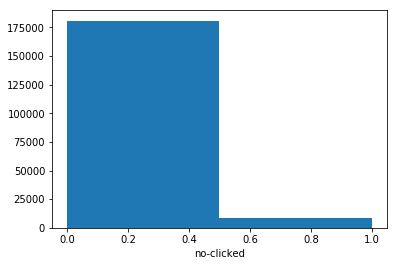

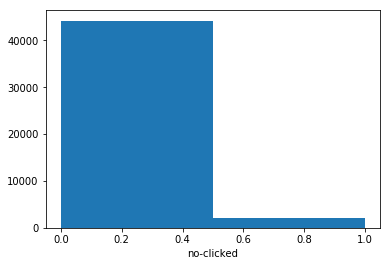

In [454]:
plt.hist(train_y.values,bins=2)
plt.xlabel('no-clicked')
plt.show()

plt.hist(val_y.values,bins=2)
plt.xlabel('no-clicked')
plt.show()

We should decimate our false data to see if we can get an improvement, but lets try normalise some of the data using min-max

In [455]:
model = RandomForestRegressor(n_estimators=100, 
                              max_features="auto", 
                              min_samples_leaf=3,
                              max_depth = 200,
                              random_state = 42,
                              n_jobs=-1, 
                              oob_score=True)

In [456]:
model.fit(train_x,train_y)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=200,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=3, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=True, random_state=42, verbose=0, warm_start=False)

In [457]:
preds = model.predict(val_x)

In [458]:
# define root mean squared percent error

def exp_rmspe(y_pred, targ):
    targ = np.exp(targ)
    pct_var = (targ - np.exp(y_pred))/targ
    return np.mean(np.sqrt(pct_var**2))

print("train accuracy = ", model.score(train_x,train_y))
print("val accuracy = ", model.score(val_x,val_y))
print("oob score = ", model.oob_score_)
print("rmse error = ", exp_rmspe(preds,val_y))

train accuracy =  0.590850639318
val accuracy =  0.118740504671
oob score =  0.0944921705755
rmse error =  0.07100776456304111


In [459]:
y_preds=np.array(np.round(preds),dtype=int)
label_map = {0:"no",1:"clicked"}

# save moodel to pickle file
import pickle

s = pickle.dumps(model)
model2 = pickle.loads(s)

with open('model.pickle','wb') as f:
    pickle.dump(model, f)


In [460]:
y_preds_words = np.vectorize(label_map.get)(y_preds)
y_val_words = np.vectorize(label_map.get)(val_y.values)

In [461]:
cnf = confusion_matrix(val_y.values, y_preds)



# Analyse data

In [462]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [472]:
X.head()

,consumer_id,mhtp,consumer_gender,proxy_id,psych_id,psych_gender,fees,sliding_scale,is_visible,bulk_billing,rebate,online_sessions,preview_display_count,preview_rank_avg,consumer_age,psych_age,years_practicing
0,90851028,1,0.0,1.0,8831884,0.0,160.000000,0.0,0,0.0,84.80000,-1.0,17,23.647059,36.0,39.981849,8.756485
1,90851028,1,0.0,1.0,8653175,1.0,199.000000,0.0,0,0.0,84.80000,-1.0,14,35.000000,36.0,39.981849,8.756485
2,95763509,1,1.0,1.0,8653175,1.0,199.000000,0.0,0,0.0,84.80000,-1.0,3,35.333333,38.0,39.981849,8.756485
3,90851028,1,0.0,1.0,8447728,0.0,176.805102,-1.0,1,-1.0,100.55836,-1.0,17,18.176471,36.0,39.981849,8.756485
4,95763509,1,1.0,1.0,8453466,1.0,195.000000,1.0,0,1.0,124.50000,-1.0,3,26.333333,38.0,50.000000,21.000000


Confusion matrix, without normalization
[[44077   120]
 [ 1949   171]]


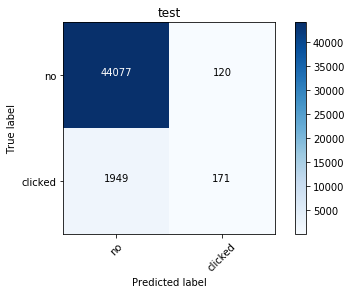

In [463]:
plot_confusion_matrix(cnf, ['no','clicked'], normalize=False,title='test')
plt.show()

In [464]:
X

,consumer_id,mhtp,consumer_gender,proxy_id,psych_id,psych_gender,fees,sliding_scale,is_visible,bulk_billing,rebate,online_sessions,preview_display_count,preview_rank_avg,consumer_age,psych_age,years_practicing
0,90851028,1,0.0,1.0,8831884,0.0,160.000000,0.0,0,0.0,84.80000,-1.0,17,23.647059,36.000000,39.981849,8.756485
1,90851028,1,0.0,1.0,8653175,1.0,199.000000,0.0,0,0.0,84.80000,-1.0,14,35.000000,36.000000,39.981849,8.756485
2,95763509,1,1.0,1.0,8653175,1.0,199.000000,0.0,0,0.0,84.80000,-1.0,3,35.333333,38.000000,39.981849,8.756485
3,90851028,1,0.0,1.0,8447728,0.0,176.805102,-1.0,1,-1.0,100.55836,-1.0,17,18.176471,36.000000,39.981849,8.756485
4,95763509,1,1.0,1.0,8453466,1.0,195.000000,1.0,0,1.0,124.50000,-1.0,3,26.333333,38.000000,50.000000,21.000000
5,95763509,1,1.0,1.0,8443112,1.0,140.000000,1.0,0,0.0,84.80000,1.0,4,21.250000,38.000000,39.981849,8.756485
6,90851028,1,0.0,1.0,8402310,-1.0,165.000000,0.0,0,0.0,84.80000,-1.0,14,29.000000,36.000000,39.981849,8.756485
7,90851028,1,0.0,1.0,8510281,1.0,124.800000,1.0,0,0.0,84.80000,-1.0,14,34.000000,36.000000,29.000000,2.000000
8,90851028,1,0.0,1.0,8274369,1.0,140.000000,1.0,1,1.0,84.80000,-1.0,17,5.352941,36.000000,38.000000,10.000000
9,93556988,0,1.0,1.0,8274369,1.0,140.000000,1.0,1,1.0,84.80000,-1.0,5,3.800000,19.000000,38.000000,10.000000


In [468]:
consumer_id = X['consumer_id'][1000]

predictions = np.round(model.predict(X.loc[X['consumer_id']==consumer_id]),3)
ids = X.loc[X['consumer_id']==consumer_id].psych_id.values

results = np.array([ids,predictions]).T

In [469]:
sorted_results = np.flipud(np.sort(results,axis=0))

In [474]:
top_5 = sorted_results[:10]

print('consumer_id:', consumer_id, '\n')
for ident in top_5:
    print('psych_id:', int(ident[0]))

consumer_id: 97368131 

psych_id: 8983256
psych_id: 8965991
psych_id: 8950888
psych_id: 8925782
psych_id: 8901988
psych_id: 8880384
psych_id: 8858215
psych_id: 8840006
psych_id: 8831243
psych_id: 8811200


In [473]:
X.loc[X['consumer_id'] == consumer_id]

,consumer_id,mhtp,consumer_gender,proxy_id,psych_id,psych_gender,fees,sliding_scale,is_visible,bulk_billing,rebate,online_sessions,preview_display_count,preview_rank_avg,consumer_age,psych_age,years_practicing
965,97368131,0,0.0,1.0,2333,0.0,176.805102,-1.0,1,1.0,100.55836,-1.0,5,10.000000,34.0,39.981849,8.756485
971,97368131,0,0.0,1.0,8671874,-1.0,176.805102,-1.0,1,-1.0,100.55836,-1.0,5,18.000000,34.0,39.981849,8.756485
972,97368131,0,0.0,1.0,8551750,1.0,190.000000,1.0,1,0.0,124.50000,1.0,8,12.250000,34.0,43.000000,8.756485
982,97368131,0,0.0,1.0,8651643,1.0,200.000000,0.0,1,0.0,124.50000,-1.0,8,4.375000,34.0,39.981849,8.756485
987,97368131,0,0.0,1.0,8004155,0.0,176.805102,-1.0,1,-1.0,100.55836,-1.0,5,21.800000,34.0,39.981849,8.756485
989,97368131,0,0.0,1.0,8983256,1.0,130.000000,0.0,0,1.0,84.80000,-1.0,8,2.000000,34.0,39.981849,8.756485
1000,97368131,0,0.0,1.0,8950888,1.0,238.000000,0.0,0,0.0,124.50000,-1.0,5,6.000000,34.0,39.981849,8.756485
1003,97368131,0,0.0,1.0,8337971,1.0,250.000000,0.0,1,0.0,84.80000,-1.0,8,8.000000,34.0,63.000000,25.000000
1011,97368131,0,0.0,1.0,8063342,0.0,176.805102,-1.0,1,-1.0,100.55836,-1.0,5,7.000000,34.0,39.981849,8.756485
1026,97368131,0,0.0,1.0,8507414,0.0,180.000000,1.0,0,0.0,84.80000,-1.0,8,15.250000,34.0,52.000000,20.000000
